In [2]:
# Imports
#%matplotlib qt
%matplotlib inline 

import matplotlib.pyplot as plt
import mne
import os
import numpy as np
import math
from scipy.stats import pearsonr
from matplotlib import cm
import pandas as pd
import matplotlib as mpl

from fooof import FOOOF
from fooof import FOOOFGroup

# To Do's - master version:

### Plotting
- Figure out how to plot topographies with nan values
    - Use MNE masks to select which channels will be plotted
        - Suggestion: add a check for which channels have data. Boolean select these channels & positions to pass into plotting.
- Reorganize notebook for which parts you have to re run

### Quantitative Corrs
- Set it up to measure correlation & plot scatterplot
    - Generally, for any band, any FOOOF feature 
        - First: set band & feature, run to see results (finish the generalization: get a scatter plot & corr)
        - Also: add to plot Medial -> Lateral (abs)
- Collect all R's into corr matrix
- Bonus: plot the corr matrix as a colored plot (red/blue). Hint: plt.imshow(matrix). Extra bonus: add a colorbar. 
        
### Per subject analysis
- Do the same spatial correlations, per subject, collect distributions of r-vals & p-vals
- Plot: boxplots of the R-values, across subjects

### Band to Band Correlations
- Amplitude-amplitude correlations between bands (across channels)
- Plot: corr-matrix

# Loading information

In [3]:
#lOADING CHANNELS FROM txt
save_path = "C:\\Users\\abc\\EEG-MNE\\data"
chan_dat = 'channel_dat.txt'
chan_file = os.path.join(save_path, chan_dat)

In [4]:
subj_dat_num = list(range(3502, 3516))
subj_dat_num2 =list(range(3001, 3015))
all_subj = subj_dat_num + subj_dat_num2

In [5]:
#LOADING CHANNELS from raw data
# This base path will need updating
base_path = 'D:\\abc\\Documents\\Research\\PBA_Data'

# These should stay the same
#subj_dat_fname = '._3001_resampled.set'
subj_dat_fname = '3002_resampled.set'
full_path = os.path.join(base_path, subj_dat_fname)
eeg_dat = mne.io.read_raw_eeglab(full_path, preload=True)

Events like the following will be dropped entirely: ['SPACE released', 'Catch_instr', 'Missed', 'Lines_On', 'M released'], 26 in total
5738/6872 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
Reading D:\abc\Documents\Research\PBA_Data\3002_resampled.fdt
Reading 0 ... 1896481  =      0.000 ...  3792.962 secs...


<ipython-input-5-a604fe0b632b>:9: RuntimeWarning: Events like the following will be dropped entirely: ['SPACE released', 'Catch_instr', 'Missed', 'Lines_On', 'M released'], 26 in total
  eeg_dat = mne.io.read_raw_eeglab(full_path, preload=True)
<ipython-input-5-a604fe0b632b>:9: RuntimeWarning: 5738/6872 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
  eeg_dat = mne.io.read_raw_eeglab(full_path, preload=True)


In [6]:
montage = mne.channels.read_montage('standard_1020', eeg_dat.ch_names)

In [7]:
eeg_dat.set_montage(montage)

<RawEEGLAB  |  3002_resampled.fdt, n_channels x n_times : 65 x 1896482 (3793.0 sec), ~940.6 MB, data loaded>

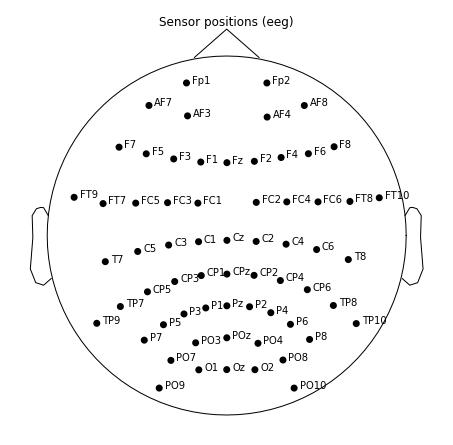

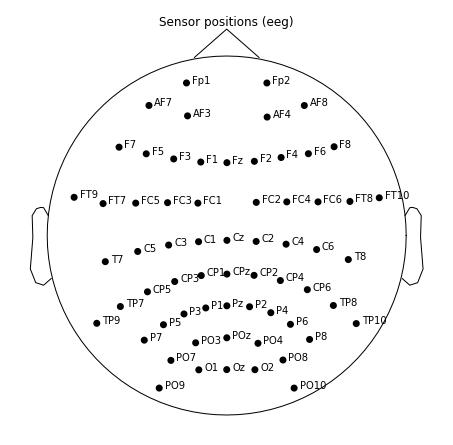

In [8]:
eeg_dat.plot_sensors(show_names=True)

In [9]:
# Extract channel positions from a subjects data object
pos_new = np.asarray([ch['loc'][:3] for ch in eeg_dat.info['chs']])

# Drop stim channel
pos_new = pos_new[:-1, :]

In [10]:
montage.pos = pos_new
pos = montage.get_pos2d()
montage = None

# DATA SET UP

In [11]:
# This is a representation 
# KEY:
# r - Rest
# t - Task
r_theta_data = np.load('..\\data\\rest_theta_group.npy')
r_alpha_data = np.load('..\\data\\rest_alpha_group.npy')
r_beta_data = np.load('..\\data\\rest_beta_group.npy')

t_theta_data = np.load('..\\data\\trial_theta_group.npy')
t_alpha_data = np.load('..\\data\\trial_alpha_group.npy')
t_beta_data = np.load('..\\data\\trial_beta_group.npy')

In [12]:
t_alpha_data.shape

(64, 3, 260)

In [13]:
t_alpha_data[0].shape

(3, 260)

In [ ]:
within_subj

In [14]:
within_subj = t_alpha_data[:,:,0] - t_alpha_data[:,:,]
np.nanmean(within_subj)

ValueError: operands could not be broadcast together with shapes (64,3) (64,3,260) 

In [15]:
r_flattened_theta = np.nanmean(r_theta_data, axis=2)
r_flattened_alpha = np.nanmean(r_alpha_data, axis=2)
r_flattened_beta = np.nanmean(r_beta_data, axis=2)

t_flattened_theta = np.nanmean(t_theta_data, axis=2)
t_flattened_alpha = np.nanmean(t_alpha_data, axis=2)
t_flattened_beta = np.nanmean(t_beta_data, axis=2)

In [16]:
# Settings - put stuff here
group_bands = {
    'theta' : r_flattened_theta,
    'alpha' : r_flattened_alpha,
    'beta' : r_flattened_beta,
}

subject_bands = {
    'theta' : r_theta_data,
    'alpha' : r_alpha_data,
    'beta' : r_beta_data,
}

# Settings - put stuff here
t_group_bands = {
    'theta' : t_flattened_theta,
    'alpha' : t_flattened_alpha,
    'beta' : t_flattened_beta,
}

t_subject_bands = {
    'theta' : t_theta_data,
    'alpha' : t_alpha_data,
    'beta' : t_beta_data,
}
# feature 0:cfs 1:amps 2:bws 
features = {
    'CFS' : 0,
    'AMPS' : 1,
    'BWS' : 2,
}

In [17]:
# Load
#f = open(chan_file, 'r')
#ch_names = f.read().splitlines()
#f.close()
# Plot stuff (don't have to change)
#montage = mne.channels.read_montage('standard_1020', eeg_dat.ch_names)
#pos = montage.get_pos2d()
# Average

# CHANNEL SET UP

In [18]:
def mask_nan_array(dat):
    return ~np.isnan(dat)

# TOPOPLOTS
## Setting up

In [19]:
band = 'alpha'
feature = 'CFS'

# Rest 

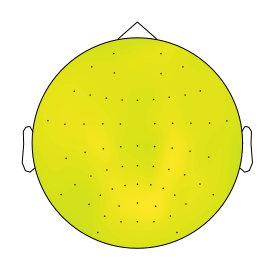

In [20]:
data = group_bands[band][:,features[feature]]
masked_arr = mask_nan_array(data)
plot = mne.viz.plot_topomap(group_bands[band][:,features[feature]][masked_arr], pos[masked_arr], cmap=cm.viridis, contours=0)

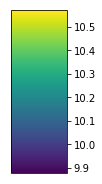

In [21]:
fig = plt.figure(figsize=(1, 3))
cmap = cm.viridis
norm = mpl.colors.Normalize(vmin=group_bands[band][:,features[feature]].min(), vmax=group_bands[band][:,features[feature]].max())
cb = mpl.colorbar.ColorbarBase(plt.gca(), cmap=cmap, norm=norm, orientation='vertical')

# Task

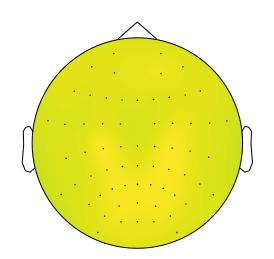

In [22]:
data = t_group_bands[band][:,features[feature]]
masked_arr = mask_nan_array(data)
plot = mne.viz.plot_topomap(t_group_bands[band][:,features[feature]][masked_arr], pos[masked_arr], cmap=cm.viridis, contours=0)

# Subtraction of Group Level Plots

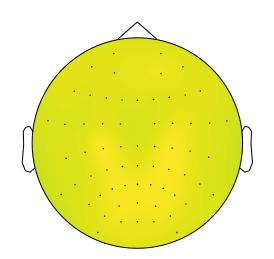

In [23]:
data =  group_bands[band][:,features[feature]] - t_group_bands[band][:,features[feature]]
masked_arr = mask_nan_array(data)
plot = mne.viz.plot_topomap(t_group_bands[band][:,features[feature]][masked_arr], pos[masked_arr], cmap=cm.viridis, contours=0)

In [24]:
np.mean(data)
# Alpha speeds up as you performa a task
# Spatial shifts and  task related shift to peak alpha frequency

-0.23289720066216313

In [25]:
# Make a table with band of interest as columns 

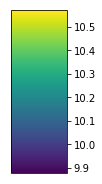

In [26]:
fig = plt.figure(figsize=(1, 3))
cmap = cm.viridis
norm = mpl.colors.Normalize(vmin=group_bands[band][:,features[feature]].min(), vmax=group_bands[band][:,features[feature]].max())
cb = mpl.colorbar.ColorbarBase(plt.gca(), cmap=cmap, norm=norm, orientation='vertical')

# SPATIAL CORRELATIONS: Position & Band Features

In [27]:
# Correlations & Plots
# Average feature value at each channel
# For posterior -> anterior
# Check: left -> right
# Check: Medial -> lateral

In [28]:
dat = group_bands[band][:,features[feature]]

In [29]:
dat

array([ 9.97456959, 10.19540401, 10.18396263, 10.11705901,  9.99478306,
       10.16590902, 10.08154701, 10.26300647, 10.07761179, 10.10065989,
       10.09496707, 10.09508146, 10.3717311 ,  9.94045604, 10.44538419,
       10.01425848,  9.90980602, 10.06829514, 10.14384792, 10.07195016,
       10.25383994, 10.07109981,  9.87755619, 10.35117784, 10.274429  ,
       10.43229799, 10.15511541,  9.9298678 , 10.22028934, 10.31459135,
       10.34118235, 10.04223495, 10.07726513, 10.10118979, 10.12671688,
       10.08071373, 10.14241041, 10.06756356, 10.01897189, 10.06033384,
       10.19703288, 10.26966659, 10.22896315, 10.24977241, 10.0932802 ,
       10.0228543 , 10.21350554, 10.05507297,  9.93958668, 10.23195235,
        9.91900311, 10.2552653 , 10.07930642, 10.49097801, 10.1795473 ,
       10.06936692, 10.3077059 , 10.25049957, 10.19886469, 10.10956329,
       10.373348  , 10.52522327, 10.56983858, 10.19999064])

# Scatter plots


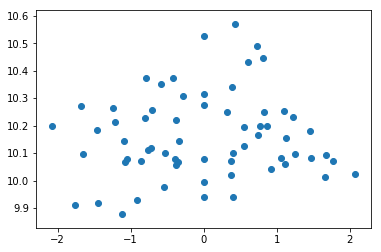

In [30]:
plt.scatter(pos[:, 0], dat)
# left to right

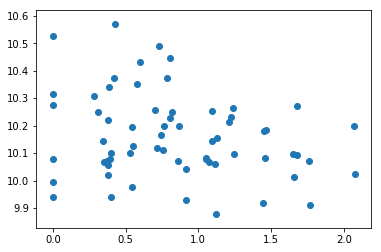

In [31]:
plt.scatter(abs(pos[:, 0]), dat)
#medial to lateral

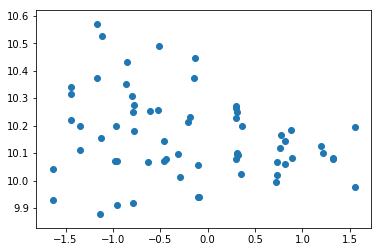

In [32]:
plt.scatter(pos[:, 1], dat)
# posterior to anterior

In [33]:
# Correlation Matrix
#  Each matrix: rows are bands, columns are FOOOF features
#    Each value is the corr value (r) between the data of that Band & Feature to a spatial dimension
#    There is a corr-matrix for each spatial dim
# Bonus: plot the matrix in colours.

In [34]:
index = group_bands.keys()
columns = features.keys()
df = pd.DataFrame(index=index, columns=columns)

for band in group_bands:
    for feature in features:
        data = group_bands[band][:,features[feature]]
        masked_arr = mask_nan_array(data)
        # pos => pos[masked_arr, 0] --> left to right
        # pos => abs(pos[masked_arr, 0]) --> medial to lateral 
        # pos => pos[masked_arr, 1] --> posterior to anterior
        corr_val = pearsonr(pos[masked_arr, 1], data[masked_arr])[0]
        df.loc[band, feature] = corr_val
    


In [35]:
df
# medial to lateral

,CFS,AMPS,BWS
theta,-0.218109,-0.394182,0.291593
alpha,-0.244379,-0.53666,-0.726878
beta,0.699782,-0.699628,-0.520779


In [36]:
df
# posterior to anterior

,CFS,AMPS,BWS
theta,-0.218109,-0.394182,0.291593
alpha,-0.244379,-0.53666,-0.726878
beta,0.699782,-0.699628,-0.520779


## Spatial Correlations: Per Subject level

Run the same correlations as above (ex. CF per channel), per subject
Collect the distributions of R values

In [37]:
# Settings
band = 'alpha'
feat = 'CFS'

In [38]:
rs = []; ps = []
a_cf = subject_bands[band][:,features[feat]]
for si in range(13):
    masked_arr = mask_nan_array(a_cf[:,si])
    # pos => pos[masked_arr, 0] --> left to right
    # pos => abs(pos[masked_arr, 0]) --> medial to lateral 
    # pos => pos[masked_arr, 1] --> posterior to anterior
    rs.append(pearsonr(pos[masked_arr, 1], a_cf[:,si][masked_arr])[0])
    #print(pearsonr(pos[masked_arr, 0], a_cf[masked_arr])[0])
    #ps[si]= pearsonr(pos[masked_arr, 0], data[masked_arr])[1]

In [39]:
rs

[-0.3907376667966307,
 -0.07762493286880054,
 0.40830154146557474,
 0.04586595697973194,
 0.3353067350746473,
 0.08900261402067418,
 0.05242808242794957,
 0.4601957252504992,
 0.06551552717270576,
 -0.04121973759110647,
 0.11210733056350743,
 -0.06629251869920472,
 0.14684235575237609]

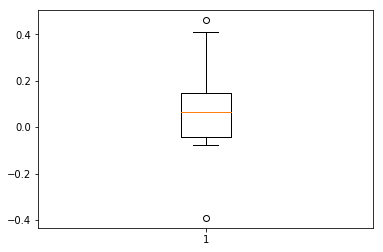

In [40]:
plt.boxplot(rs);

# Spatial Correlations Between Bands

In [41]:
feature = 'CFS'

In [42]:
index = group_bands.keys()
d_corrm = pd.DataFrame(index=index)
#Dataframe for correlaton matrix
for band in group_bands:
    data = group_bands[band][:,features[feature]]
    masked_arr = mask_nan_array(data)
    # pos => pos[masked_arr, 0] --> left to right
    # pos => abs(pos[masked_arr, 0]) --> medial to lateral 
    # pos => pos[masked_arr, 1] --> posterior to anterior
    

In [43]:
index = group_bands.keys()
d_corrm = pd.DataFrame(index=index, columns=index, dtype = float)
#Dataframe for correlaton matrix
for band in group_bands:
    data1 = group_bands[band][:,features[feature]]
    for band2 in group_bands:
        data2 = group_bands[band2][:,features[feature]]
        masked_arr1=mask_nan_array(data1)
        masked_arr2=mask_nan_array(data2)
        corr_val = pearsonr(data1, data2)[0]
        d_corrm.loc[band, band2] = corr_val


In [44]:
d_corrm

,theta,alpha,beta
theta,1.000000,0.177929,-0.197946
alpha,0.177929,1.000000,-0.136034
beta,-0.197946,-0.136034,1.000000


In [45]:
d_corrm.values

array([[ 1.        ,  0.17792886, -0.19794619],
       [ 0.17792886,  1.        , -0.13603371],
       [-0.19794619, -0.13603371,  1.        ]])

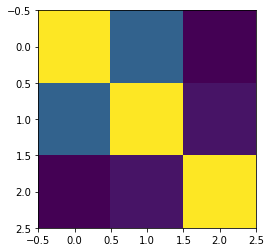

In [46]:
plt.imshow(d_corrm)